## Accessing Sentinel-3 SYNERGY data with the Planetary Computer STAC API

The [Sentinel 3 SYNERGY products](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-3-synergy) are produced by fusing data from both the OLCI and SLSTR instruments.
The Planetary Computer hosts five SYNERGY collections:

- Aerosol Optical Depth: `sentinel-3-synergy-aod-l2-netcdf`
- Land Surface Reflectance and Aerosol: `sentinel-3-synergy-syn-l2-netcdf`
- 10-Day Surface Reflectance and NDVI: `sentinel-3-synergy-v10-l2-netcdf`
- 1-Day Surface Reflectance and NDVI: `sentinel-3-synergy-vg1-l2-netcdf`
- Top of Atmosphere Reflectance: `sentinel-3-synergy-vgp-l2-netcdf`

This notebook will demonstrate data access and visualization for all five collections.

### Data Access

This notebook works with or without an API key, but you will be given more permissive access to the data with an API key. If you are using the [Planetary Computer Hub](https://planetarycomputer.microsoft.com/compute) to run this notebook, then your API key is automatically set to the environment variable `PC_SDK_SUBSCRIPTION_KEY` for you when your server is started. Otherwise, you can view your keys by signing in to the [developer portal](https://planetarycomputer.developer.azure-api.net/). The API key may be manually set via the environment variable `PC_SDK_SUBSCRIPTION_KEY` or the following code:

```python
import planetary_computer
planetary_computer.settings.set_subscription_key(<YOUR API Key>)
```

The datasets hosted by the Planetary Computer are available in [Azure Blob Storage](https://docs.microsoft.com/en-us/azure/storage/blobs/). We'll use [pystac-client](https://pystac-client.readthedocs.io/) to search the Planetary Computer's [STAC API](https://planetarycomputer.microsoft.com/api/stac/v1/docs) for the subset of the data that we care about, and then we'll load the data directly from Azure Blob Storage. We'll specify a `modifier` so that we can access the data stored in the Planetary Computer's private Blob Storage Containers. See [Reading from the STAC API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) and [Using tokens for data access](https://planetarycomputer.microsoft.com/docs/concepts/sas/) for more.



### Land Surface Reflectance

The collection's description provides more information about the land surface reflectance product.

In [1]:
import planetary_computer
import pystac_client
from IPython.display import display, Markdown

catalog = pystac_client.Client.open(
    "https://pct-apis-staging.westeurope.cloudapp.azure.com/stac/",
    modifier=planetary_computer.sign_inplace,
)
collection = catalog.get_collection("sentinel-3-synergy-syn-l2-netcdf")

display(Markdown(f"# {collection.id}\n\n{collection.description}"))

# sentinel-3-synergy-syn-l2-netcdf

This Collection provides the Sentinel-3 [Synergy Level-2 Land Surface Reflectance and Aerosol](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-3-synergy/product-types/level-2-syn) product, which contains data on Surface Directional Reflectance, Aerosol Optical Thickness, and an Angstrom coefficient estimate over land.

## Data Files

Individual NetCDF files for the following variables:

- Surface Directional Reflectance (SDR) with their associated error estimates for the sun-reflective [SLSTR](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-3-slstr) channels (S1 to S6 for both nadir and oblique views, except S4) and for all [OLCI](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-3-olci) channels, except for the oxygen absorption bands Oa13, Oa14, Oa15, and the water vapor bands Oa19 and Oa20.
- Aerosol optical thickness at 550nm with error estimates.
- Angstrom coefficient at 550nm.

More information about the product and data processing can be found in the [User Guide](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-3-synergy/product-types/level-2-syn) and [Technical Guide](https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-3-synergy/level-2/syn-level-2-product).

This Collection contains Level-2 data in NetCDF files from September 2018 to present.


### Define the area of interest and search the water collection

We'll search for items at `[-105, 40]`.

In [2]:
import xarray as xr
import fsspec

search = catalog.search(
    collections=["sentinel-3-synergy-syn-l2-netcdf"],
    intersects={"type": "Point", "coordinates": [-105, 40]},
)
item = next(search.items())

### Available Assets and Metadata

Each item includes a handful of assets linking to NetCDF files with the data or additional metadata files.

In [3]:
import rich.table

t = rich.table.Table("Key", "Value")
for key, asset in item.assets.items():
    t.add_row(key, asset.description)

t

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Key                        ┃ Value                                                                              ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ time                       │ Time stamps annotation                                                             │
│ syn-amin                   │ L2 Aerosol model index number data                                                 │
│ syn-flags                  │ Classification and quality Flags associated with OLCI, SLSTR and SYNERGY products  │
│ syn-ato550                 │ Aerosol Optical Thickness Data Set                                                 │
│ geolocation                │ High resolution georeferencing data                                                │
│ safe-manifest              │ SAFE product manifest                                                              │
│ tiepoints-olci             │ Low resolution georeferencing data and Sun and View angles associated with OLCI    │
│                            │ products                                                                           │
│ tiepoints-meteo            │ ECMWF meteorology data                                                             │
│ tiepoints-slstr-n          │ Low resolution georeferencing data and Sun and View angles associated with SLSTR   │
│                            │ nadir view products                                                                │
│ tiepoints-slstr-o          │ Low resolution georeferencing data and Sun and View angles associated with SLSTR   │
│                            │ oblique view products                                                              │
│ syn-angstrom-exp550        │ Aerosol Angstrom Exponent Data Set                                                 │
│ syn-s1n-reflectance        │ Surface directional reflectance associated with SLSTR channel 01 acquired in nadir │
│                            │ view                                                                               │
│ syn-s1o-reflectance        │ Surface directional reflectance associated with SLSTR channel 01 acquired in       │
│                            │ oblique view                                                                       │
│ syn-s2n-reflectance        │ Surface directional reflectance associated with SLSTR channel 02 acquired in nadir │
│                            │ view                                                                               │
│ syn-s2o-reflectance        │ Surface directional reflectance associated with SLSTR channel 02 acquired in       │
│                            │ oblique view                                                                       │
│ syn-s3n-reflectance        │ Surface directional reflectance associated with SLSTR channel 03 acquired in nadir │
│                            │ view                                                                               │
│ syn-s3o-reflectance        │ Surface directional reflectance associated with SLSTR channel 03 acquired in       │
│                            │ oblique view                                                                       │
│ syn-s5n-reflectance        │ Surface directional reflectance associated with SLSTR channel 05 acquired in nadir │
│                            │ view                                                                               │
│ syn-s5o-reflectance        │ Surface directional reflectance associated with SLSTR channel 05 acquired in       │
│                            │ oblique view                                                                       │
│ syn-s6n-reflectance        │ Surface directional reflectance associated with SLSTR channel 06 acquired in nadir │
│                            │ view                     

### Reading data

We can use xarray to read each NetCDF file directly from Blob Storage.
Let's load in red, green, and blue bands from the NetCDF.
We load in georeferencing information from the `geolocation` asset.

In [4]:
geo = xr.open_dataset(fsspec.open(item.assets["geolocation"].href).open())
geo

<xarray.Dataset>
Dimensions:   (rows: 4090, columns: 4865)
Dimensions without coordinates: rows, columns
Data variables:
    altitude  (rows, columns) float32 ...
    lat       (rows, columns) float64 ...
    lon       (rows, columns) float64 ...
Attributes: (12/15)
    absolute_orbit_number:  35790
    comment:                 
    contact:                eosupport@copernicus.esa.int
    creation_time:          2023-01-02T11:58:48Z
    history:                  2023-01-02T11:58:48Z: PUGCoreProcessor joborder...
    institution:            PS1
    ...                     ...
    references:             S3IPF PDS 006 - i1r14 - Product Data Format Speci...
    resolution:             [ 300 300 ]
    source:                 IPF-SY-2 06.23
    start_time:             2022-12-31T17:07:32.600174Z
    stop_time:              2022-12-31T17:10:32.521268Z
    title:                  SYN L2, high resolution georeferencing data

In [5]:
keys = [
    "syn-oa08-reflectance",
    "syn-oa05-reflectance",
    "syn-oa03-reflectance",
]


def read(key: str) -> xr.Dataset:
    dataset = xr.open_dataset(fsspec.open(item.assets[key].href).open())
    dataset = dataset.assign_coords(
        {
            "lat": geo.lat,
            "lon": geo.lon,
        }
    )
    return dataset


datasets = [read(key) for key in keys]
dataset = xr.combine_by_coords(datasets, join="exact", combine_attrs="drop_conflicts")
dataset

<xarray.Dataset>
Dimensions:       (rows: 4090, columns: 4865)
Coordinates:
    lat           (rows, columns) float64 41.98 41.98 41.98 ... 29.08 29.08
    lon           (rows, columns) float64 -110.9 -110.9 -110.9 ... -99.25 -99.25
Dimensions without coordinates: rows, columns
Data variables:
    SDR_Oa03      (rows, columns) float32 ...
    SDR_Oa03_err  (rows, columns) float32 ...
    SDR_Oa05      (rows, columns) float32 ...
    SDR_Oa05_err  (rows, columns) float32 ...
    SDR_Oa08      (rows, columns) float32 ...
    SDR_Oa08_err  (rows, columns) float32 ...
Attributes: (12/14)
    absolute_orbit_number:  35790
    comment:                 
    contact:                eosupport@copernicus.esa.int
    creation_time:          2023-01-02T11:58:48Z
    history:                  2023-01-02T11:58:48Z: PUGCoreProcessor joborder...
    institution:            PS1
    ...                     ...
    product_name:           S3A_SY_2_SYN____20221231T170733_20221231T171033_2...
    references:             S3IPF PDS 006 - i1r14 - Product Data Format Speci...
    resolution:             [ 300 300 ]
    source:                 IPF-SY-2 06.23
    start_time:             2022-12-31T17:07:32.600174Z
    stop_time:              2022-12-31T17:10:32.521268Z

### Visualize  

We create a three-band data array for visualization.

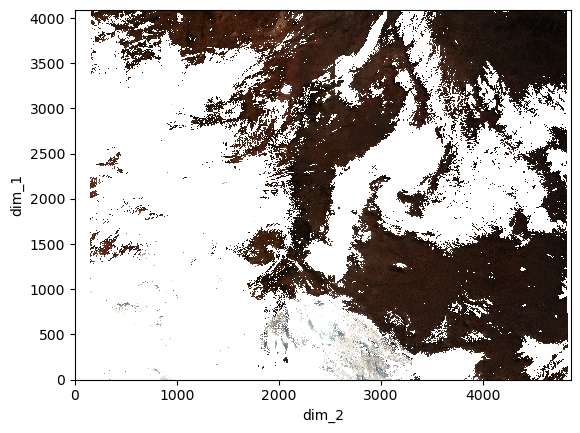

In [6]:
from matplotlib import pyplot

axes = pyplot.axes()
xr.DataArray(data=[dataset.SDR_Oa08, dataset.SDR_Oa05, dataset.SDR_Oa03]).plot.imshow(
    axes=axes
)
pyplot.show()

### Surface reflectance and NDVI

We'll now do a similar procedure for the two surface reflectance and NDVI products.

In [7]:
collection = catalog.get_collection("sentinel-3-synergy-v10-l2-netcdf")
display(Markdown(f"# {collection.id}\n\n{collection.description}"))

# sentinel-3-synergy-v10-l2-netcdf

This Collection provides the Sentinel-3 [Synergy Level-2 10-Day Surface Reflectance and NDVI](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-3-synergy/product-types/level-2-vg1-v10) products, which are SPOT VEGETATION Continuity Products similar to those obtained from the [VEGETATION instrument](https://docs.terrascope.be/#/Satellites/SPOT-VGT/MissionInstruments) onboard the SPOT-4 and SPOT-5 satellites. The primary variables are a maximum Normalized Difference Vegetation Index (NDVI) composite, which is derived from ground reflectance during a 10-day window, and four surface reflectance bands:

- B0 (Blue, 450nm)
- B2 (Red, 645nm)
- B3 (NIR, 835nm)
- MIR (SWIR, 1665nm)

The four reflectance bands have center wavelengths matching those on the original SPOT VEGETATION instrument. The NDVI variable, which is an indicator of the amount of vegetation, is derived from the B3 and B2 bands.

## Data files

The four reflectance bands and NDVI values are each contained in dedicated NetCDF files. Additional metadata are delivered in annotation NetCDF files, each containing a single variable, including the geometric viewing and illumination conditions, the total water vapour and ozone columns, and the aerosol optical depth.

Each 10-day product is delivered as a set of 10 rectangular scenes:

- AFRICA
- NORTH_AMERICA
- SOUTH_AMERICA
- CENTRAL_AMERICA
- NORTH_ASIA
- WEST_ASIA
- SOUTH_EAST_ASIA
- ASIAN_ISLANDS
- AUSTRALASIA
- EUROPE

More information about the product and data processing can be found in the [User Guide](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-3-synergy/product-types/level-2-vg1-v10) and [Technical Guide](https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-3-synergy/vgt-s/v10-product).

This Collection contains Level-2 data in NetCDF files from September 2018 to present.


In [8]:
collection = catalog.get_collection("sentinel-3-synergy-vg1-l2-netcdf")
display(Markdown(f"# {collection.id}\n\n{collection.description}"))

# sentinel-3-synergy-vg1-l2-netcdf

This Collection provides the Sentinel-3 [Synergy Level-2 1-Day Surface Reflectance and NDVI](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-3-synergy/product-types/level-2-vg1-v10) products, which are SPOT VEGETATION Continuity Products similar to those obtained from the [VEGETATION instrument](https://docs.terrascope.be/#/Satellites/SPOT-VGT/MissionInstruments) onboard the SPOT-4 and SPOT-5 satellites. The primary variables are a maximum Normalized Difference Vegetation Index (NDVI) composite, which is derived from daily ground reflecrtance, and four surface reflectance bands:

- B0 (Blue, 450nm)
- B2 (Red, 645nm)
- B3 (NIR, 835nm)
- MIR (SWIR, 1665nm)

The four reflectance bands have center wavelengths matching those on the original SPOT VEGETATION instrument. The NDVI variable, which is an indicator of the amount of vegetation, is derived from the B3 and B2 bands.

## Data files

The four reflectance bands and NDVI values are each contained in dedicated NetCDF files. Additional metadata are delivered in annotation NetCDF files, each containing a single variable, including the geometric viewing and illumination conditions, the total water vapour and ozone columns, and the aerosol optical depth.

Each 1-day product is delivered as a set of 10 rectangular scenes:

- AFRICA
- NORTH_AMERICA
- SOUTH_AMERICA
- CENTRAL_AMERICA
- NORTH_ASIA
- WEST_ASIA
- SOUTH_EAST_ASIA
- ASIAN_ISLANDS
- AUSTRALASIA
- EUROPE

More information about the product and data processing can be found in the [User Guide](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-3-synergy/product-types/level-2-vg1-v10) and [Technical Guide](https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-3-synergy/vgt-s/vg1-product-surface-reflectance).

This Collection contains Level-2 data in NetCDF files from October 2018 to present.


In [9]:
search = catalog.search(
    collections=["sentinel-3-synergy-v10-l2-netcdf"],
    intersects={"type": "Point", "coordinates": [-105, 40]},
)
item = next(search.items())
t = rich.table.Table("Key", "Value")
for key, asset in item.assets.items():
    t.add_row(key, asset.description)

t

┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Key           ┃ Value                                                        ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ ag            │ Aerosol optical thickness data                               │
│ b0            │ Surface Reflectance Data Set associated with VGT-B0 channel  │
│ b2            │ Surface Reflectance Data Set associated with VGT-B2 channel  │
│ b3            │ Surface Reflectance Data Set associated with VGT-B3 channel  │
│ og            │ Total Ozone column data                                      │
│ sm            │ Status Map data                                              │
│ tg            │ Synthesis time data                                          │
│ mir           │ Surface Reflectance Data Set associated with VGT-MIR channel │
│ saa           │ Solar azimuth angle data                                     │
│ sza           │ Solar zenith angle data                                      │
│ vaa           │ View azimuth angle data                                      │
│ vza           │ View zenith angle data                                       │
│ wvg           │ Total column Water vapour data                               │
│ ndvi          │ Normalised difference vegetation index                       │
│ safe-manifest │ SAFE product manifest                                        │
└───────────────┴──────────────────────────────────────────────────────────────┘

Let's visualize the NDVI.

In [10]:
dataset = xr.open_dataset(fsspec.open(item.assets["ndvi"].href).open())
dataset

<xarray.Dataset>
Dimensions:    (latitude: 3921, longitude: 18705, crs: 1, vertices: 2)
Coordinates:
  * crs        (crs) object 'EPSG:https://www.opengis.net/def/crs/EPSG/0/4326'
  * latitude   (latitude) float64 75.0 74.99 74.98 74.97 ... 40.02 40.01 40.0
  * longitude  (longitude) float64 -180.0 -180.0 -180.0 ... -13.02 -13.01 -13.0
Dimensions without coordinates: vertices
Data variables:
    NDVI       (latitude, longitude) float32 ...
    lat_bnds   (latitude, vertices) float64 ...
    lon_bnds   (longitude, vertices) float64 ...
Attributes: (12/14)
    comment:               
    contact:              eosupport@copernicus.esa.int
    creation_time:        2023-04-23T14:30:56Z
    history:                2023-04-23T14:30:56Z: PUGCoreProcessor JobOrder.2...
    institution:          PS2
    netCDF_version:       4.2 of Mar 29 2022 09:28:14 $
    ...                   ...
    references:           S3IPF PDS 006 - i1r14 - Product Data Format Specifi...
    resolution:           [ 1000 1000 ]
    source:               IPF-SY-2-VGS 06.11
    start_time:           2023-04-11T00:00:00.000000Z
    stop_time:            2023-04-20T23:59:59.000000Z
    title:                SYN VGT-S Level 2 Product, Normalized difference ve...

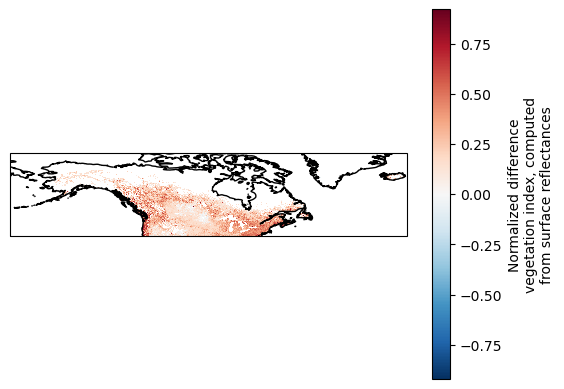

In [11]:
from cartopy.crs import PlateCarree

axes = pyplot.axes(projection=PlateCarree())
dataset["NDVI"].plot.imshow(axes=axes)
axes.coastlines()
pyplot.show()

The one-day product is quite similar.

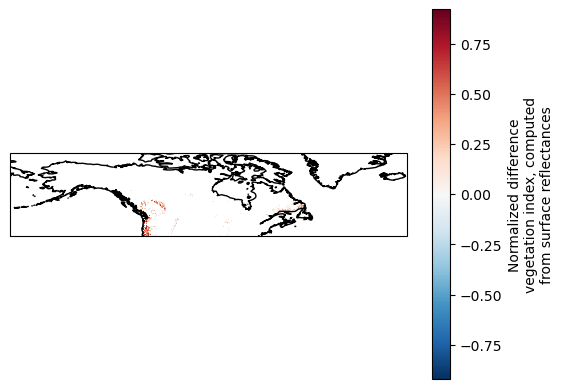

In [12]:
search = catalog.search(
    collections=["sentinel-3-synergy-vg1-l2-netcdf"],
    intersects={"type": "Point", "coordinates": [-105, 40]},
)
item = next(search.items())
dataset = xr.open_dataset(fsspec.open(item.assets["ndvi"].href).open())
axes = pyplot.axes(projection=PlateCarree())
dataset["NDVI"].plot.imshow(axes=axes)
axes.coastlines()
pyplot.show()

### Top of atmosphere reflectance

Top of atmosphere reflectance is similar, but it's a less commonly-used product and its visualizations aren't quite as intuitive.
The data are also quite large, so we have to be careful not to crash our kernel while building our visualization.

In [13]:
collection = catalog.get_collection("sentinel-3-synergy-vgp-l2-netcdf")
display(Markdown(f"# {collection.id}\n\n{collection.description}"))

# sentinel-3-synergy-vgp-l2-netcdf

This Collection provides the Sentinel-3 [Synergy Level-2 Top of Atmosphere Reflectance](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-3-synergy/product-types/level-2-vgp) product, which is a SPOT VEGETATION Continuity Product containing measurement data similar to that obtained by the [VEGETATION instrument](https://docs.terrascope.be/#/Satellites/SPOT-VGT/MissionInstruments) onboad the SPOT-3 and SPOT-4 satellites. The primary variables are four top of atmosphere reflectance bands:

- B0 (Blue, 450nm)
- B2 (Red, 645nm)
- B3 (NIR, 835nm)
- MIR (SWIR, 1665nm)

The four reflectance bands have center wavelengths matching those on the original SPOT VEGETATION instrument and have been adapted for scientific applications requiring highly accurate physical measurements through correction for systematic errors and re-sampling to predefined geographic projections. The pixel brightness count is the ground area's apparent reflectance as seen at the top of atmosphere.

## Data files

NetCDF files are provided for the four reflectance bands. Additional metadata are delivered in annotation NetCDF files, each containing a single variable, including the geometric viewing and illumination conditions, the total water vapour and ozone columns, and the aerosol optical depth.

More information about the product and data processing can be found in the [User Guide](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-3-synergy/product-types/level-2-vgp) and [Technical Guide](https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-3-synergy/level-2/vgt-p-product).

This Collection contains Level-2 data in NetCDF files from October 2018 to present.


In [14]:
search = catalog.search(
    collections=["sentinel-3-synergy-vgp-l2-netcdf"],
    intersects={"type": "Point", "coordinates": [-105, 40]},
)
item = next(search.items())
t = rich.table.Table("Key", "Value")
for key, asset in item.assets.items():
    t.add_row(key, asset.description)

t

┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Key           ┃ Value                                                                      ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ ag            │ Aerosol optical thickness data                                             │
│ b0            │ Top of atmosphere reflectance data set associated with the VGT-B0 channel  │
│ b2            │ Top of atmosphere reflectance data set associated with the VGT-B2 channel  │
│ b3            │ Top of atmosphere reflectance data set associated with the VGT-B3 channel  │
│ og            │ Total ozone column data                                                    │
│ sm            │ Status map data                                                            │
│ mir           │ Top of atmosphere Reflectance data set associated with the VGT-MIR channel │
│ saa           │ Solar azimuth angle data                                                   │
│ sza           │ Solar zenith angle data                                                    │
│ vaa           │ View azimuth angle data                                                    │
│ vza           │ View zenith angle data                                                     │
│ wvg           │ Total column water vapour data                                             │
│ safe-manifest │ SAFE product manifest                                                      │
└───────────────┴────────────────────────────────────────────────────────────────────────────┘

In [15]:
dataset = xr.open_dataset(fsspec.open(item.assets["b0"].href).open())
dataset

<xarray.Dataset>
Dimensions:    (latitude: 14672, longitude: 40320, crs: 1, vertices: 2)
Coordinates:
  * longitude  (longitude) float64 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * latitude   (latitude) float64 75.0 74.99 74.98 ... -55.97 -55.98 -55.99
  * crs        (crs) object 'EPSG:https://www.opengis.net/def/crs/EPSG/0/4326'
Dimensions without coordinates: vertices
Data variables:
    B0         (latitude, longitude) float32 ...
    lat_bnds   (latitude, vertices) float64 ...
    lon_bnds   (longitude, vertices) float64 ...
Attributes: (12/15)
    title:                  SYN, VGP TOA reflectance associated with VGT B0 c...
    netCDF_version:         4.2 of Mar 13 2018 10:14:33 $
    product_name:           S3A_SY_2_VGP____20230116T164731_20230116T173123_2...
    institution:            PS1
    source:                 IPF-SY-2 06.23
    history:                 
    ...                     ...
    resolution:             [ 1000 1000 ]
    absolute_orbit_number:  36018
    start_time:             2023-01-16T16:47:30.637922Z
    stop_time:              2023-01-16T17:31:23.277077Z
    processing_baseline:    SYN_L2_.002.16.00
    comment:

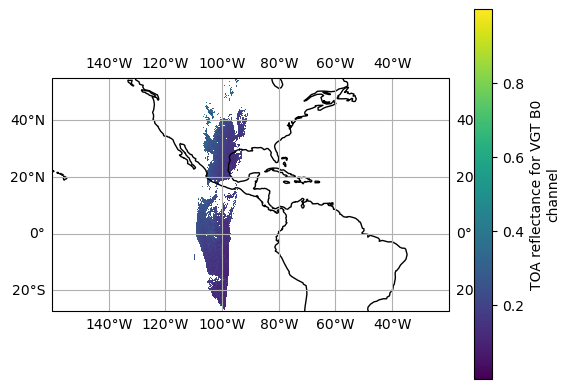

In [33]:
import numpy

data = dataset.B0.where(~numpy.isnan(dataset.B0), drop=True)

axes = pyplot.axes(projection=PlateCarree())
axes.coastlines()
axes.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
data.plot.imshow(axes=axes)
axes.set_xlim(-160, -20)

pyplot.show()

### Aerosol Optical Depth

Finally, let's explore the Aerosol Optical Depth product.

In [34]:
collection = catalog.get_collection("sentinel-3-synergy-aod-l2-netcdf")
display(Markdown(f"# {collection.id}\n\n{collection.description}"))

# sentinel-3-synergy-aod-l2-netcdf

This Collection provides the Sentinel-3 [Synergy Level-2 Aerosol Optical Depth](https://sentinels.copernicus.eu/web/sentinel/level-2-aod) product, which is a downstream development of the Sentinel-2 Level-1 [OLCI Full Resolution](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-3-olci/data-formats/level-1) and [SLSTR Radiances and Brightness Temperatures](https://sentinels.copernicus.eu/web/sentinel/user-guides/Sentinel-3-slstr/data-formats/level-1) products. The dataset provides both retrieved and diagnostic global aerosol parameters at super-pixel (4.5 km x 4.5 km) resolution in a single NetCDF file for all regions over land and ocean free of snow/ice cover, excluding high cloud fraction data. The retrieved and derived aerosol parameters are:

- Aerosol Optical Depth (AOD) at 440, 550, 670, 985, 1600 and 2250 nm
- Error estimates (i.e. standard deviation) in AOD at 440, 550, 670, 985, 1600 and 2250 nm
- Single Scattering Albedo (SSA) at 440, 550, 670, 985, 1600 and 2250 nm
- Fine-mode AOD at 550nm
- Aerosol Angstrom parameter between 550 and 865nm
- Dust AOD at 550nm
- Aerosol absorption optical depth at 550nm

Atmospherically corrected nadir surface directional reflectances at 440, 550, 670, 985, 1600 and 2250 nm at super-pixel (4.5 km x 4.5 km) resolution are also provided. More information about the product and data processing can be found in the [User Guide](https://sentinels.copernicus.eu/web/sentinel/level-2-aod) and [Technical Guide](https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-3-synergy/products-algorithms/level-2-aod-algorithms-and-products).

This Collection contains Level-2 data in NetCDF files from April 2020 to present.


In [35]:
search = catalog.search(
    collections=["sentinel-3-synergy-aod-l2-netcdf"],
    intersects={"type": "Point", "coordinates": [-105, 40]},
)
item = next(search.items())
t = rich.table.Table("Key", "Value")
for key, asset in item.assets.items():
    t.add_row(key, asset.description)

t

┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Key           ┃ Value                     ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ ntc-aod       │ Global aerosol parameters │
│ safe-manifest │ SAFE product manifest     │
└───────────────┴───────────────────────────┘

In [36]:
dataset = xr.open_dataset(fsspec.open(item.assets["ntc-aod"].href).open())
dataset

<xarray.Dataset>
Dimensions:                          (rows: 3988, columns: 324)
Dimensions without coordinates: rows, columns
Data variables: (12/48)
    AOD_440                          (rows, columns) float32 ...
    AOD_440_uncertainty              (rows, columns) float32 ...
    AOD_550                          (rows, columns) float32 ...
    AOD_550_uncertainty              (rows, columns) float32 ...
    AOD_670                          (rows, columns) float32 ...
    AOD_670_uncertainty              (rows, columns) float32 ...
    ...                               ...
    cloud_fraction_nadir             (rows, columns) float32 ...
    cloud_fraction_oblique           (rows, columns) float32 ...
    aod_quality_flags                (rows, columns) float32 ...
    OL_L1b_quality_flags             (rows, columns) uint32 ...
    SLN_L1b_quality_flags            (rows, columns) uint32 ...
    SLO_L1b_quality_flags            (rows, columns) uint32 ...
Attributes: (12/15)
    title:                  Surface directional Reflectance, retrieved and de...
    comment:                 
    netCDF_version:         4.2 of Mar 13 2018 10:14:33 $
    product_name:           S3A_SY_2_AOD____20230116T164731_20230116T173123_2...
    institution:            PS1
    source:                 IPF-SY-2-AOD 01.06
    ...                     ...
    creation_time:          2023-01-18T08:50:29Z
    resolution:             [ 4500 4500 ]
    absolute_orbit_number:  36018
    start_time:             2023-01-16T16:47:30.637922Z
    stop_time:              2023-01-16T17:31:23.277077Z
    processing_baseline:    AOD_NTC.002.06.01

In [40]:
import pandas

data = (
    pandas.DataFrame(
        {
            "longitude": dataset.longitude.data.ravel(),
            "latitude": dataset.latitude.data.ravel(),
            "aod": dataset.AOD_670.load().data.ravel(),
        }
    )
    .dropna()
    .sample(10000)
)
data

,longitude,latitude,aod
335660,-98.889343,17.484486,0.0615
775526,-116.388824,-34.273056,0.0475
388973,-105.782837,12.249413,0.0862
199455,-99.530869,34.838272,0.0326
197160,-100.629143,35.314102,0.0282
...,...,...,...
490273,-112.435608,0.935065,0.1462
734240,-120.411438,-28.022366,0.0358
338499,-101.827652,17.780157,0.2428
776400,-120.550591,-33.404602,0.0291


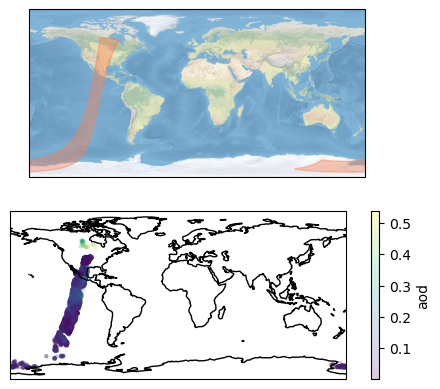

In [42]:
import shapely.geometry
from cartopy.crs import PlateCarree
from matplotlib import pyplot

figure = pyplot.figure()

axes = figure.add_subplot(2, 1, 1, projection=PlateCarree())
axes.add_geometries(
    shapely.geometry.shape(item.geometry), crs=PlateCarree(), color="coral", alpha=0.4
)
axes.stock_img()

axes = figure.add_subplot(2, 1, 2, projection=PlateCarree())
data.plot.scatter(
    x="longitude",
    y="latitude",
    c="aod",
    ax=axes,
    colormap="viridis",
    marker=".",
    alpha=0.2,
)
axes.coastlines()
axes.set_ylim(-90, 90)

pyplot.show()